In [27]:
import numpy as np
import matplotlib.pyplot as plt

In [28]:
np.random.seed(16)

## 1. Implement a data structure for general computation graphs and define the node types required to support feed-forward neural networks with a variety of activation functions.

### 1.1. Activation Functions

In [31]:
def relu(Z):
    return np.maximum(0, Z)

def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

### 1.2. Data Structure

#### Let:
* $m$ = number of samples (batch size)
* The input $X$
$$X \in \mathbb{R}^{n_x \times m}$$
* The target $Y$
$$Y \in \mathbb{R}^{n_y \times m}$$
* $L$ = total number of layers
* *layer_sizes* $\rightarrow$ A list with integers representing the number of units at every layer, in sequence. (Length = $L$)
* $n^{[l]}$ = number of units in layer $l$
* *activation_functions* $\rightarrow$ A list representing the activation functions used at every layer (Length = $L$)
* Learning Rate ($\alpha$)

#### For each layer $l$, we have:

* Weight Matrix $W^{[l]}$:
$$W^{[l]} \in \mathbb{R}^{n^{[l]} \times n^{[l-1]}}$$
* Bias Vector $b^{[l]}$:
$$b^{[l]} \in \mathbb{R}^{n^{[l]} \times 1}$$
* Linear Unit Output Matrix $Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$:
$$Z^{[l]} \in \mathbb{R}^{n^{[l]} \times m}$$
* Non-Linear Activation Function Output Matrix $A^{[l]} = g\left(Z^{[l]}\right)$:
$$A^{[l]} \in \mathbb{R}^{n^[l] \times m}$$
$$A^{[0]} = X \in \mathbb{R}^{n_x \times m}$$
* Loss Function Output $L \rightarrow$ Binary cross-entropy for classification
$$L \in \mathbb{R}$$

#### Forward Propagation Equations:
$$Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$$
$$(n^{[l]} \times m) = (n^{[l]} \times n^{[l-1]})(n^{[l-1]} \times m) + (n^{[l]} \times 1)$$


In [36]:
m = 1000
activation_functions = [relu] * 3 + [sigmoid]
layer_sizes = [50, 20, 10, 1]

# Let's define an artificial input that is the X1 and X2 coordinates on a plot, indicating a point in 2D
X = np.random.randn(2, 1000) * 5
# I am defining an artificial target that is True if the point in 2D falls inside of a circle of radius=5, False otherwise
Y_labels = ((X[0]**2 + X[1]**2) <= 25)
Y = Y_labels.reshape(1, -1)

learning_rate = 0.0075

The goal is to train a network capable of idenitfying the circumference of radius equal to 5 as the decision boundary

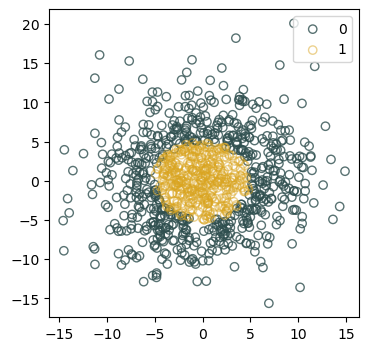

In [39]:
plt.figure(figsize=[4, 4])
plt.scatter(X[0, False == Y_labels], X[1, False == Y_labels], label = 0, facecolors = 'none', edgecolors = 'darkslategray', alpha=0.8)
plt.scatter(X[0, Y_labels], X[1, Y_labels], facecolors='none', edgecolors='goldenrod', label = 1, alpha = 0.5)
plt.legend()
plt.show()

##### Initialize the weights (W) and bias (b) parameters in the network

In [42]:
def initialize_params(X, layer_sizes):
    
    parameters = {}
    nx = X.shape[0]
    layer_sizes = [nx] + layer_sizes
    
    for l in range(1, len(layer_sizes)):
        
        parameters[f'W{l}'] = np.random.randn(layer_sizes[l], layer_sizes[l-1]) * 0.001
        parameters[f'b{l}'] = np.zeros((layer_sizes[l], 1))
        
    return parameters

In [44]:
params = initialize_params(X, layer_sizes)

### 2. Write a function that computes the outputs of the computation graph given the inputs.

In [47]:
def calculate_linear (A_prior, W, b):
    
    Z = W @ A_prior + b
    
    return Z

In [49]:
def calculate_activation(Z, activation_function):

    return activation_function(Z)

In [51]:
def forward_propagation(X, params, activation_functions):
    
    num_layers = int(len(params) / 2)
    Z = {}
    A = {}
    W = {}
    b = {}
    
    for l in range(1, num_layers + 1):
        W[l], b[l] = params[f'W{l}'], params[f'b{l}']
        if l == 1:
            Z[l] = calculate_linear(X, W[l], b[l])
        else:
            Z[l] = calculate_linear(A[l-1], W[l], b[l])
        A[l] = calculate_activation(Z[l], activation_functions[l-1])
    
    return A, Z

In [53]:
A, Z = forward_propagation(X, params, activation_functions)

### 3. Write a function that computes the error for a labeled example

The loss function I am going to use is binary cross-entropy, which is used for binary classification tasks

In [57]:
def calculate_loss(A_output, Y):
    
    m = Y.shape[1] # Number of samples
    epsilon = 1e-15  # Small constant to prevent log(0)
    
    A_output = np.clip(A_output, epsilon, 1 - epsilon)
    
    loss = ((-1) * np.sum((Y * np.log(A_output)) + ((1 - Y) * np.log(1 - A_output)))) / m
    loss = loss.item()
    
    return loss

In [59]:
loss = calculate_loss(A[len(A)], Y)
print(loss) 

0.6931471805869192


We can see that the loss is quite high, since we have not trained the network yet.

### 4. Implement back-propagation and use it to create a stochastic gradient descent learning algorithm for a set of examples. 

#### Backpropagation Gradients (applying the chain rule):

With respect to $Z$:
$$\frac{\partial L}{\partial Z^{[l]}} \in \mathbb{R}^{n^{[l]} \times m}$$
$$\frac{\partial L}{\partial Z^{[l]}} = \frac{\partial L}{\partial A^{[l]}} \frac{\partial A^{[l]}}{\partial Z^{[l]}} = \frac{\partial L}{\partial A^{[l]}} \odot g'^{[l]}(Z^{[l]})$$
$$(n^{[l]} \times m) = (n^{[l]} \times m) \odot (n^{[l]} \times m)$$
With respect to $W$:
$$\frac{\partial L}{\partial W^{[l]}} \in \mathbb{R}^{n^{[l]} \times n^{[l-1]}}$$
$$\frac{\partial L}{\partial W^{[l]}} = \frac{\partial L}{\partial Z^{[l]}} \frac{\partial Z^{[l]}}{\partial W^{[l]}} = \frac{1}{m}\frac{\partial L}{\partial Z^{[l]}}(A^{[l-1]})^T$$
$$(n^{[l]} \times n^{[l-1]}) = \frac{1}{m}(n^{[l]} \times m)(m \times n^{[l-1]})$$
With respect to $b$:
$$\frac{\partial L}{\partial b^{[l]}} \in \mathbb{R}^{n^{[l]} \times 1}$$
$$\frac{\partial L}{\partial b^{[l]}} = \frac{\partial L}{\partial Z^{[l]}} \frac{\partial Z^{[l]}}{\partial b^{[l]}} = \frac{1}{m}\sum_{i=1}^m\frac{\partial L}{\partial Z^{[l]}}$$
$$(n^{[l]} \times 1) = \frac{1}{m}\sum_{i=1}^m(n^{[l]} \times m)$$
With respect to the previous layer activation:
$$\frac{\partial L}{\partial A^{[l-1]}} \in \mathbb{R}^{n^{[l-1]} \times m}$$
$$\frac{\partial L}{\partial A^{[l-1]}} = \frac{\partial L}{\partial Z^{[l]}} \frac{\partial Z^{[l]}}{\partial A^{[l-1]}} = (W^{[l]})^T\frac{\partial L}{\partial Z^{[l]}}$$
$$(n^{[l-1]} \times m) = (n^{[l-1]} \times n^{[l]})(n^{[l]} \times m)$$

$\frac{\partial L}{\partial A^{[L]}}$

In [65]:
def grad_loss(A_output, Y):
    """
    #### Arguments ####:
    A_output: output from the last layer (A[l]), which given the loss function should signify a probability (that is why the
                last activation function in my network is the sigmoid)
    Y: Target (vector of labels, indicating "true" (1) or "false" (0))

    #### Output ####:
    dL_dA_output: derivative of the loss function with respect to the output of the network
    """
    dL_dA_output = - (np.divide(Y, A_output) - np.divide(1 - Y, 1 - A_output))

    return dL_dA_output

$\frac{\partial A^{[l]}}{\partial Z^{[l]}}$

In [68]:
def grad_activation(Z, activation_function):
    """
    #### Arguments ####:
    Z: linear output from layer l (a.k.a. input to the activation function of layer l)

    #### Output ####:
    dA_dZ: derivative of the activation function of layer l with respect to Z of layer l
    """

    if activation_function == sigmoid:
        A = activation_function(Z)
        dA_dZ = A * (1-A)
    if activation_function == relu:
        dA_dZ = (Z > 0).astype(float)

    return dA_dZ

##### Backpropagation function

In [71]:
def backpropagation(A, Z, params, activation_functions, Y, X):
    """
    #### Arguments ####:
    A: dictionary with the outputs from the activation function at every layer
    Z: dictionary with the linear outputs at every layer
    params: dictionary with the parameters at every layer
    activation_functions: list of activation functions at every layer
    Y: Target (vector of labels, indicating "true" (1) or "false" (0))

    #### Output ####:
    gradients : dictionary with the gradients of the loss function with respect to the parameters at every layer
        dW[l]: gradient with respect to the weights from layer l
        db[l]: gradient with respect to the biases from layer l
    """
    
    gradients = {}
    
    m = Y.shape[0]
    L = len(A)

    dL_dA = grad_loss(A[L], Y)
    
    for l in reversed(range(1, L + 1)):
        A_prev = A[l-1] if l > 1 else X
        dZ = dL_dA * grad_activation(Z[l], activation_functions[l-1])
        # Compute gradients
        gradients[f'dW{l}'] = (1/m) * np.dot(dZ, A_prev.T)
        gradients[f'db{l}'] = (1/m) * np.sum(dZ, axis=1, keepdims=True)
        
        if l > 1:
            dL_dA = np.dot(params[f'W{l}'].T, dZ)
            
    return gradients

In [73]:
def update_parameters(parameters, gradients, learning_rate):
    """
    #### Arguments ####:
    parameters: dictionary with the parameters at every layer
    gradients: dictionary with the gradients of the loss function with respect to the parameters at every layer
    learning_rate: learning rate (fixed) for stochastic gradient descent

    #### Output ####:
    parameters : updated parameters
    """

    L = int(len(parameters) / 2)
    for l in range(1, L + 1):
        parameters[f'W{l}'] -= learning_rate * gradients[f'dW{l}']
        parameters[f'b{l}'] -= learning_rate * gradients[f'db{l}']

    return parameters

### 5. Train the model

In [76]:
def train_model(layer_sizes, X, Y, activation_functions, learning_rate, iterations = 5000):
    
    nl = len(layer_sizes)
    losses = []

    params = initialize_params(X, layer_sizes)

    for i in range(1, iterations + 1):
        if i % 2000 == 0:
            print(f"Iteration {i} - Loss: {losses[-1]}", end='\n')
        A, Z = forward_propagation(X, params, activation_functions)
        losses.append(calculate_loss(A[nl], Y))
        gradients = backpropagation(A, Z, params, activation_functions, Y, X)
        params = update_parameters(params, gradients, learning_rate)

    return params

In [78]:
params = train_model(layer_sizes, X, Y, activation_functions, learning_rate, iterations = 10000)

Iteration 2000 - Loss: 0.673011666951791
Iteration 4000 - Loss: 0.6730116668759606
Iteration 6000 - Loss: 0.6730116666701835
Iteration 8000 - Loss: 0.6730116658072489
Iteration 10000 - Loss: 0.6730116503242992
